In [1]:
%load_ext autoreload
%autoreload 2

# Dataset:

bajarlo de Kagle:

https://www.kaggle.com/ml-lab-itba/yolointroitbadataset

In [2]:
import numpy as np

In [3]:
reduced_dataset_folder = '/home/usuario/repos/Object_Localization/challenge_dataset'

In [4]:
train_folder = reduced_dataset_folder + '/images/train'
val_folder = reduced_dataset_folder + '/images/val'

In [5]:
annotations_dict_train = np.load(reduced_dataset_folder+'/annotations_train.npy').flat[0]
annotations_dict_val = np.load(reduced_dataset_folder+'/annotations_val.npy').flat[0]

In [6]:
classes = list(annotations_dict_train.keys())
print(classes)

['n04487081', 'n02108089', 'n02701002', 'n02279972', 'n04008634']


In [7]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [8]:
datagen_train = ImageDataGenerator(rescale=1./255, horizontal_flip=False)
batch_size = 64
train_generator = datagen_train.flow_from_directory(
    classes = classes,
    directory=train_folder,
    target_size=(375, 500),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 1250 images belonging to 5 classes.


In [9]:
datagen_val = ImageDataGenerator(rescale=1./255, horizontal_flip=False)
batch_size = 64
val_generator = datagen_val.flow_from_directory(
    classes = classes,
    directory=val_folder,
    target_size=(375, 500),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 250 images belonging to 5 classes.


In [10]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

In [11]:
n_classes = len(classes)

In [12]:
N_trainable = 17
modelVGG16 = VGG16(include_top=False, weights='imagenet')
GAP = GlobalAveragePooling2D()(modelVGG16.output)
classification = Dense(n_classes, 
                           activation='softmax', 
                           name='category_output')(GAP)
model = Model(inputs=modelVGG16.input, outputs=classification)
print('Primer capa entrenable:', model.layers[N_trainable].name)
for layer in model.layers[N_trainable:]:
    layer.trainable = True
for layer in model.layers[:N_trainable]:
    layer.trainable = False

Primer capa entrenable: block5_conv3


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [54]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, rmsprop, SGD
filename = 'classif_runtime'
checkpoint = ModelCheckpoint(filepath = filename+'_best.hdf5', 
                             monitor='val_acc', save_best_only=True)
model.compile(loss=["categorical_crossentropy"],
              optimizer=Adam(lr=0.001),
              metrics=["accuracy"])

In [55]:
from object_detection_helper import PlotLosses

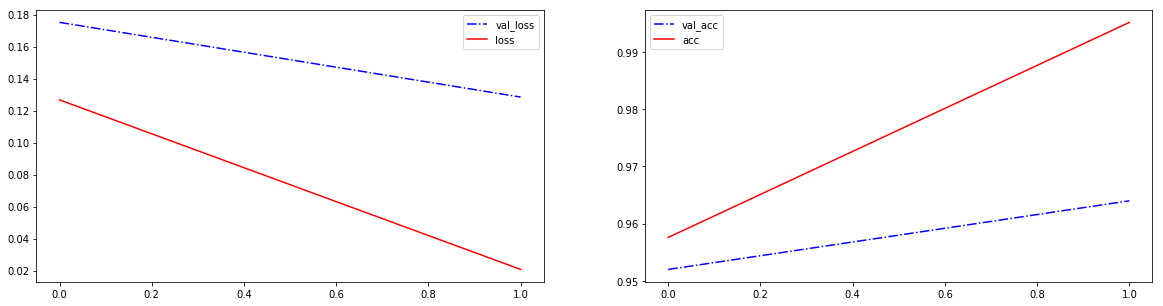

In [56]:
plot_losses = PlotLosses(1)
model.fit_generator(
        train_generator,
        #steps_per_epoch=steps_per_epoch,
        epochs=2,
        validation_data=val_generator, 
        callbacks = [plot_losses, checkpoint]
        )

# Modelo sin capas densas

## Supongamos una unput shape

In [42]:
from keras.layers import Conv2D

In [40]:
input_shape=(375, 500,3)
N_trainable = 17
modelVGG16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
#modelVGG16.summary()
output = modelVGG16.layers[-1].output
print(output)
last_w = output.shape[1].value
last_h = output.shape[2].value
print(last_w, last_h)
# Notar que el shape cambia al cambiar la entrada

Tensor("block5_pool_19/MaxPool:0", shape=(?, 11, 15, 512), dtype=float32)
11 15


In [45]:
dense_conv = Conv2D(filters = n_classes, kernel_size = (last_w, last_h), activation='softmax', name='category_output')
classification = dense_conv(modelVGG16.output)
model = Model(inputs=modelVGG16.input, outputs=classification)

In [49]:
print('Primer capa entrenable:', model.layers[N_trainable].name)
for layer in model.layers[N_trainable:]:
    layer.trainable = True
for layer in model.layers[:N_trainable]:
    layer.trainable = False

Primer capa entrenable: block5_conv3


In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 375, 500, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 375, 500, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 375, 500, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 187, 250, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 187, 250, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 187, 250, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 93, 125, 128)      0         
__________